In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys

sys.path.append("../EDA")
DATA_PATH = "../instruction/movieReplicationSet.csv"
ALPHA = 0.005


In [2]:
import movie_data_formatter as mdf
import movie_rating_popularity_year as mrpy
import general_functions as gf

df = pd.read_csv(DATA_PATH)
df = mdf.clean_data(df)
processed_data = mdf.convert_to_movie_reviews_table(df)
movie_popular_data = mrpy.get_movie_aggregation(processed_data)

In [3]:
processed_data.head()

,report_id,movie_name,rating,year
0,1.0,The Life of David Gale,NaN,2003
1,1.0,Wing Commander,NaN,1999
2,1.0,Django Unchained,4.0,2012
3,1.0,Alien,NaN,1979
4,1.0,Indiana Jones and the Last Crusade,3.0,1989


In [4]:
movie_popular_data.head()

,movie_name,count_num_reviews,average_rating,year,popularity_level,year_level
0,10 Things I Hate About You,544,3.242647,1999,high,new
1,10000 BC,176,2.264205,2008,low,new
2,12 Monkeys,136,2.606618,1995,low,old
3,13 Going on 30,661,2.888048,2004,high,new
4,21 Grams,67,2.253731,2003,low,new


# Question 1: 

Are movies that are more popular (operationalized as having more ratings) rated higher than movies that 
are less popular? [Hint: You can do a median-split of popularity to determine high vs. low popularity movies]  

# Visualizations


From the visualization, we can notice that when the popularity level is low, the average rating tends to between 2.0 to 2.2 whereas when popularity level is high
the the range tends to be between 2.7 and 3.1.

<module 'matplotlib.pyplot' from '/Users/paolacalle/Desktop/NYU/semesters/fall-2025/ds/projects/movie-ratings-replication/my_project_env/lib/python3.13/site-packages/matplotlib/pyplot.py'>

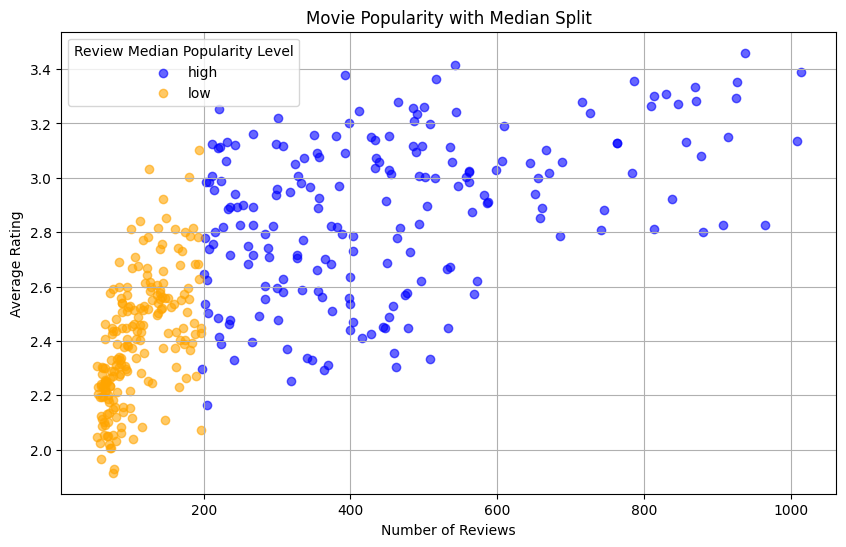

In [5]:
mrpy.plot_popular_median_split(movie_popular_data, show=False)

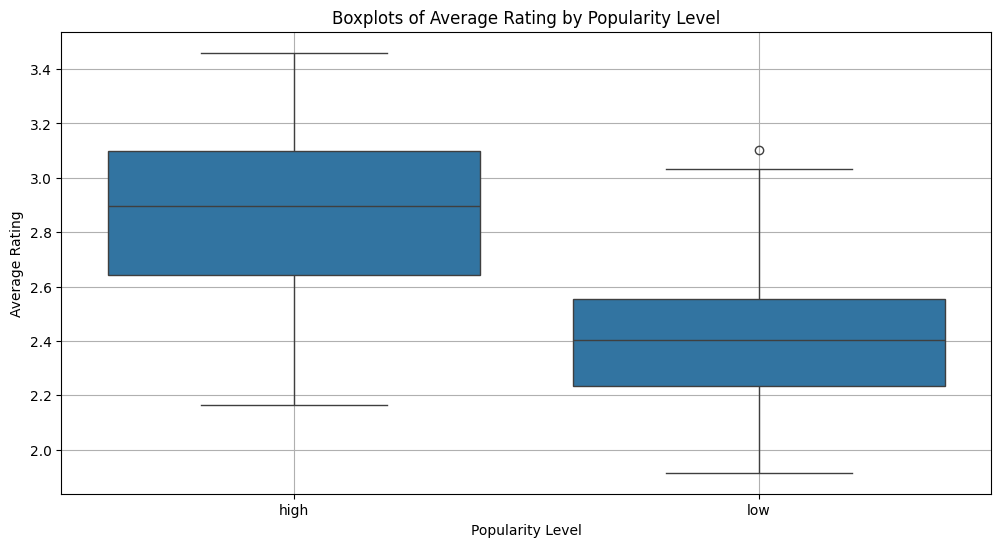

<module 'matplotlib.pyplot' from '/Users/paolacalle/Desktop/NYU/semesters/fall-2025/ds/projects/movie-ratings-replication/my_project_env/lib/python3.13/site-packages/matplotlib/pyplot.py'>

In [6]:
mrpy.boxplot_popularity_median_split(movie_popular_data, show=True)

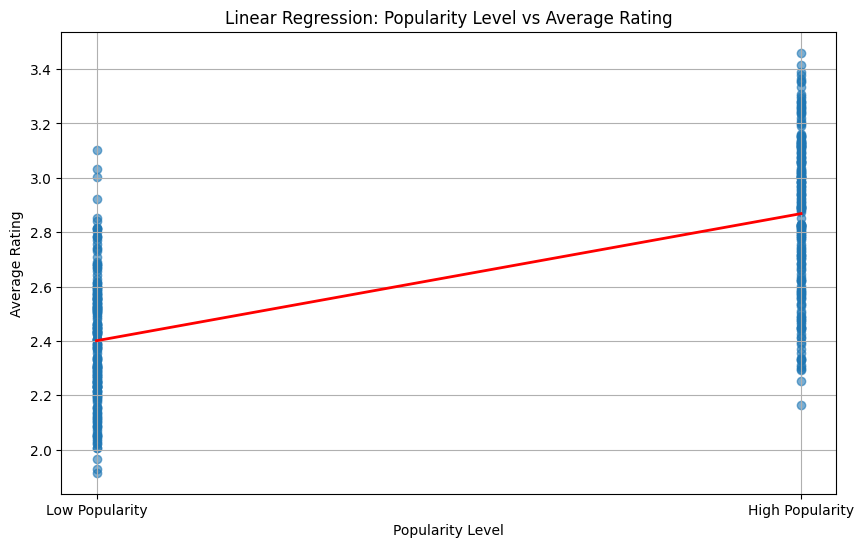

<module 'matplotlib.pyplot' from '/Users/paolacalle/Desktop/NYU/semesters/fall-2025/ds/projects/movie-ratings-replication/my_project_env/lib/python3.13/site-packages/matplotlib/pyplot.py'>

In [7]:
mrpy.plot_linear_regression_median_split(movie_popular_data)

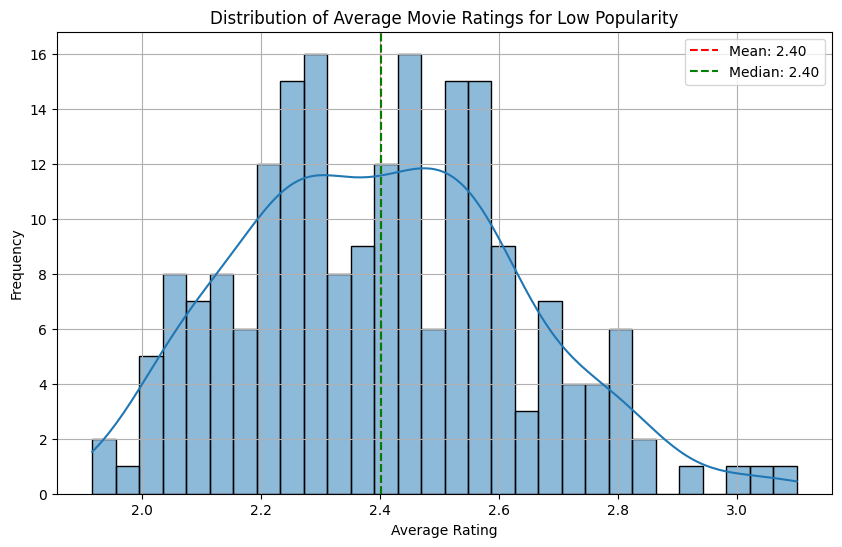

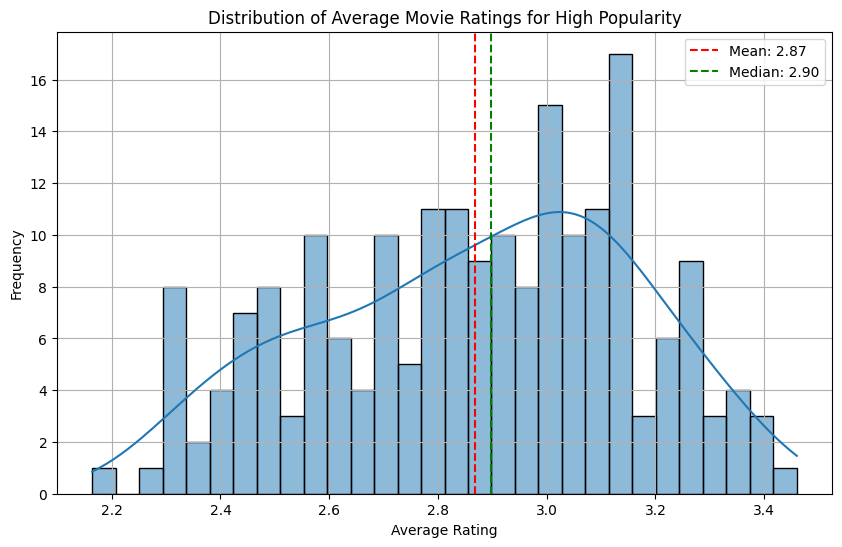

<module 'matplotlib.pyplot' from '/Users/paolacalle/Desktop/NYU/semesters/fall-2025/ds/projects/movie-ratings-replication/my_project_env/lib/python3.13/site-packages/matplotlib/pyplot.py'>

In [8]:
lowess_popular = movie_popular_data[movie_popular_data['popularity_level'] == 'low']
highess_popular = movie_popular_data[movie_popular_data['popularity_level'] == 'high']
gf.plot_distrubtion(lowess_popular, "Low Popularity", y='average_rating', show=True)
gf.plot_distrubtion(highess_popular, "High Popularity", y='average_rating', show=True)

# Hypothesis Testing



## Mann–Whitney U test
We will use a Mann–Whitney U test because:
- The two groups (low-popularity and high-popularity movies) are independent.
- The rating distributions are non-normal and not perfectly similar in shape, violating the assumptions of parametric tests like the t-test.
- The Mann–Whitney U test does not assume normality and is robust to unequal variances and outliers.
- It allows for a one-sided hypothesis, aligning with our research question about whether high-popularity movies tend to receive higher ratings.

### Setup 
Let:
- X1 = Ratings of low-popularity movies
- X2 = Ratings of high-popularity movies

H0 : The distributions of X1 and X2 are identical.

H1 : X2 tends to yield larger values than X1.

This is a right-tailed (one-sided) Mann–Whitney U test, testing whether high-popularity movies have higher median ratings.

In [9]:
stat, p = stats.mannwhitneyu(lowess_popular['average_rating'], highess_popular['average_rating'], alternative='less')

gf.is_p_drop("Mann-Whitney U Test", stat, p, "median", ALPHA)

Mann-Whitney U Test: 4596.000, p-value: 0.0000
Drop H0 --> accept H1


The Kruskal–Wallis H test revealed a significant difference among groups.  

## Welch’s t-test
Since the low-popularity and high-popularity movie groups are not extremely skewed and each contains at least 30 observations, 
the Central Limit Theorem allows us to assume approximate normality of the sampling distribution of the mean.

Therefore, a Welch’s t-test (which does not assume equal variances) is appropriate for comparing the average ratings 
between the two groups.

### Setup

Let:
- u1 = mean rating for low-popularity movies
- u2 = mean rating for high-popularity movies

We want to test whether high popularity leads to higher observed ratings.

H0: u1 = u2
H1: u2 > u1


In [10]:
stat, p = stats.ttest_ind(lowess_popular['average_rating'], 
                          highess_popular['average_rating'], 
                          equal_var=False, alternative='less')

gf.is_p_drop("T-test", stat, p, ALPHA)

T-test: -17.756, p-value: 0.0000
Drop H0 --> accept H1


Since the p-value is effectively 0.0000 (< 0.05), we drop the null hypothesis.
There is strong statistical evidence that high-popularity movies have significantly higher average ratings compared to low-popularity movies. 

In other words, popularity level is positively associated with average rating -- more popular movies tend to receive better audience evaluations.

# Conclusion 

We performed both a Welch’s t-test and a Mann–Whitney U test to assess whether 
high-popularity movies have higher ratings than low-popularity movies.

Both tests produced p-values < 0.001, leading us to reject the null hypothesis 
and conclude that high-popularity movies tend to have significantly higher 
ratings. The agreement between parametric (mean-based) and non-parametric 
(rank-based) results increases confidence in this finding.
